## Classification of Objects in selected bricks into ELG, LRG, QSO

In [66]:
import sys
import numpy as np
import pandas
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from astropy.io import ascii
import random
import matplotlib.pyplot as plt
import wget
import seaborn as sns
import random
import os
import warnings
import time

warnings.filterwarnings("ignore")
random.seed(666)
#import healpy

### Defining colour cuts

In [67]:
def is_LRG_target(g,r,z,W1):
    if not (18.01 < z < 20.41):
        return False
    if not (0.75 < (r - z) < 2.45):
        return False
    if not (-0.6 < (z - W1) - 0.8*(r - z)):
        return False
    if not ((z - 17.18)/2 < (r - z) < (z - 15.11)/2):
        return False
    if not (((r - z) > 1.15) or ((g-r) > 1.65)):
        return False
    return True
    
def is_ELG_target(g,r,z):
    if not (21.0 < g < 23.45):
        return False
    if not (0.3 < (r - z) < 1.6):
        return False
    if not ((g-r) < 1.15*(r-z) - 0.15):
        return False
    if not ((g-r) < 1.6 - 1.2*(r-z)):
        return False
    return True

def is_QSO_target(g,r,z,maskbit):
    if r > 22.7:
        return False
    if r < 17.5:
        return False
    if not g - r < 1.3:
        return False
    if not (-0.4 < r - z < 1.1):
        return False
    return True
        

### Getting bricks data

In [74]:
hdulistBricksSummary = fits.open('../bricks_data/survey-bricks-dr9-south.fits')
dataSummary = hdulistBricksSummary[1].data
bricknameSummary = dataSummary.field('brickname')
brickidSummary = dataSummary.field('brickid')
brick_galaxy_info = np.array([[220271,34,10,177]])

## Classification Loop
#### Steps:
##### 1. Download a randomly sampled brick
##### 2. Calculate extinction corrected magnitudes ( m=22.5−2.5log10(flux))
##### 3. Apply colour cuts
##### 4. Delete brick data

In [75]:
start = time.time()

for i in range(1000):
    
    #Sampling a random brick and preparing the data
    randomint = random.randint(0, len(bricknameSummary))
    brickname = bricknameSummary[randomint] 
    brickid = brickidSummary[randomint] 
    
    folder = brickname[:3]
    url = f'https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/{folder}/tractor-{brickname}.fits'
    wget.download(url, '../bricks_data/tractor/')
    
    hdulistSingleBrick = fits.open(f'../bricks_data/tractor/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    
    #fluxes and magnitude
    flux_g = data.field('flux_g')
    flux_r = data.field('flux_r')
    flux_z = data.field('flux_z')
    flux_w1 = data.field('flux_w1')
    flux_w2 = data.field('flux_w2')
    flux_w3 = data.field('flux_w3')
    flux_w4 = data.field('flux_w4')

    mw_transmission_g = data.field('mw_transmission_g')
    mw_transmission_r = data.field('mw_transmission_r')
    mw_transmission_z = data.field('mw_transmission_z')
    mw_transmission_w1 = data.field('mw_transmission_w1')
    mw_transmission_w2 = data.field('mw_transmission_w2')
    mw_transmission_w3 = data.field('mw_transmission_w3')
    mw_transmission_w4  = data.field('mw_transmission_w4')

    #correcting for extinction
    flux_g_corrected = flux_g - mw_transmission_g
    flux_r_corrected = flux_r - mw_transmission_r
    flux_z_corrected = flux_z - mw_transmission_z
    flux_w1_corrected = flux_w1 - mw_transmission_w1
    flux_w2_corrected = flux_w2 - mw_transmission_w2
    flux_w3_corrected = flux_w3 - mw_transmission_w3
    flux_w4_corrected = flux_w4 - mw_transmission_w4



    mag_g = 22.5-2.5*np.log10(flux_g_corrected)
    mag_r = 22.5-2.5*np.log10(flux_r_corrected)
    mag_z = 22.5-2.5*np.log10(flux_z_corrected)
    mag_w1 = 22.5-2.5*np.log10(flux_w1_corrected)
    mag_w2 = 22.5-2.5*np.log10(flux_w2_corrected)
    mag_w3 = 22.5-2.5*np.log10(flux_w3_corrected)
    mag_w4 = 22.5-2.5*np.log10(flux_w4_corrected)

    #Retrieving the maskbits for quasar detection

    maskbits = data.field('maskbits')

    target_label_array = np.zeros(len(mag_g))
    for i in range(len(mag_g)):
        if is_LRG_target(mag_g[i], mag_r[i], mag_z[i], mag_w1[i]):
            target_label_array[i] = 1
            continue
        if is_ELG_target(mag_g[i], mag_r[i], mag_z[i]):
            target_label_array[i] = 2
            continue
        if is_QSO_target(mag_g[i], mag_r[i], mag_z[i], maskbits[i]):
            target_label_array[i] = 3
            continue
            
    lrg = (target_label_array == 1).sum()
    elg = (target_label_array == 2).sum()
    qso = (target_label_array == 3).sum()
    
    summary_stats = np.array([[brickid,lrg,elg,qso]])

    brick_galaxy_info = np.append(brick_galaxy_info, summary_stats, axis=0)
    
    os.remove(f'../bricks_data/tractor/tractor-{brickname}.fits')
    
    if i % 50 == 0:  
        print(f"Bricks finished: {i}/1000")

print(brick_galaxy_info)

print("Time taken: ", time.time()- start)

Bricks finished: 5000/1000
Bricks finished: 5150/1000
Bricks finished: 4400/1000
Bricks finished: 8300/1000
Bricks finished: 9650/1000
Bricks finished: 8850/1000
Bricks finished: 6000/1000
Bricks finished: 5800/1000
Bricks finished: 3550/1000
Bricks finished: 5800/1000
Bricks finished: 8750/1000
Bricks finished: 8350/1000
Bricks finished: 4350/1000
Bricks finished: 4750/1000
Bricks finished: 4900/1000
Bricks finished: 8750/1000
Bricks finished: 6650/1000
Bricks finished: 750/1000
Bricks finished: 4250/1000
Bricks finished: 8150/1000
Bricks finished: 6950/1000
Bricks finished: 5250/1000
Bricks finished: 8150/1000
Bricks finished: 5800/1000
[[220271     34     10    177]
 [488055     42      4    372]
 [325364     41      1    272]
 ...
 [347429      0      0      0]
 [356213     36      0    232]
 [351350     62      4    288]]
Time taken:  4617.492434978485


In [76]:
print(len(brick_galaxy_info))


1001


### Beginning preliminary analysis

In [78]:
sample = brick_galaxy_info
nexp_gSummary = dataSummary.field('nexp_g')
nexp_rSummary = dataSummary.field('nexp_r')
nexp_zSummary = dataSummary.field('nexp_z')



In [79]:
print(sample.shape)

(1001, 4)


In [85]:
sample = np.c_[sample, np.zeros(len(sample))]
print(sample.shape)
print(sample)

(1001, 7)
[[2.20271e+05 3.40000e+01 1.00000e+01 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [4.88055e+05 4.20000e+01 4.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.25364e+05 4.10000e+01 1.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 ...
 [3.47429e+05 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.56213e+05 3.60000e+01 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.51350e+05 6.20000e+01 4.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]


In [93]:
print(sample[:,0])
ind = 0
for j in range(len(brickidSummary)):
    if sample[0,0] == brickidSummary[j]:
        ind = j
print(ind)
print(nexp_gSummary[ind])
print(nexp_rSummary[ind])
print(nexp_zSummary[ind])


[220271. 488055. 325364. ... 347429. 356213. 351350.]
49956
8
8
7


In [91]:
sampled = sample
for i in range(len(sampled)):
    index = 0
    for j in range(len(brickidSummary)):
        if sampled[i,0] == brickidSummary[j]:
            index = j
    sampled[i, 4] = nexp_gSummary[index]
    sampled[i, 5] = nexp_rSummary[index]
    sampled[i, 6] = nexp_zSummary[index]

[2.20271e+05 3.40000e+01 1.00000e+01 1.77000e+02 8.00000e+00 8.00000e+00
 7.00000e+00]


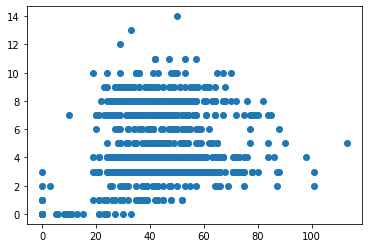

In [99]:
plt.scatter(sampled[:,1], sampled[:,4])
plt.show()